In [1]:
from __future__ import print_function, division
%matplotlib inline

import os

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]="0,1,2,3"

from itertools import chain
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from IPython.core.debugger import set_trace
import itertools
import seaborn as sns
from tqdm import tqdm
import random
import cv2
from natsort import natsorted
import collections
import skimage
from IPython import display
import pylab as pl
from sklearn.preprocessing import MinMaxScaler
plt.ion()

# Check cuda.is_available ?

In [2]:
cuda_available = torch.cuda.is_available()
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print("cuda_available : {}, device : {}".format(cuda_available, device))

cuda_available : True, device : cuda:0


# Define Dataset & DataLoader

In [3]:
MAXLEN = 300
FPS = 24.0

def drop_huge_seq(input_df, save_path="./preprocess/example_data/person_detection_and_tracking_results_drop.pkl"):
    if os.path.exists(save_path):
        print('Already dropped! Return...')
        return
    
    vids = list(set(input_df.vids))

    for i in tqdm(range(len(vids)), desc='DropInputSeq '):
        slice_df = input_df.loc[input_df.vids==vids[i]]
        if slice_df.values.shape[0] > MAXLEN:
            input_df.iloc[slice_df.index] = np.nan * np.ones_like(slice_df.values)

    # drop Nans !
    res_df = input_df.dropna()
    res_df.to_pickle("./preprocess/example_data/person_detection_and_tracking_results_drop.pkl")

input_df = pd.read_csv('./preprocess/example_data/person_detection_and_tracking_results.csv',
                       sep='\t', names=['vids', 'idx', 'pos'])
    
# drop huge seq
drop_huge_seq(input_df, save_path="./preprocess/example_data/person_detection_and_tracking_results_drop.pkl")

Already dropped! Return...


In [4]:
df = pd.read_pickle('./preprocess/example_data/person_detection_and_tracking_results_drop.pkl')
len(list(set(df.vids)))

2806

In [5]:
df = pd.read_pickle("./preprocess/data/targets_dataframe.pkl")
target_columns = df.columns.values[:-2]
# target_columns = ['Toe In / Out/L', 'Toe In / Out/R']

In [6]:
def pid2vid(pid):
    num, test_id, trial_id = pid.split('_')
    return '_'.join([num, 'test', test_id, 'trial', trial_id])
    

def vid2pid(vid):
    split = vid.split('_')
    return '_'.join([split[0], split[2], split[4]])
    
class GAITDataset(Dataset):
    def __init__(self,
                 frame_home, input_file, target_file,
                 phase, split_ratio, normalize_target=False, maxlen=300, r_seed=3):
        
        self.maxlen = maxlen
        self.frame_home = frame_home

        # input dataframe
        input_df = pd.read_pickle(input_file)
        
        # target dataframe
        target_df = pd.read_pickle(target_file)[target_columns]
        
        vids = list(set(input_df.vids))
        
        # reindex tgt data (to filter-out valid vids)
        pids = []
        for vid in vids:
            pids.append(vid2pid(vid))

        target_df = target_df.reindex(pids)
        
        # remove rows with any 0.0 values
        target_df = target_df[(target_df.T!=0).all()]
        
        # vids without zero values in target df
        vids = [ pid2vid(pid) for pid in target_df.index.values ][:16]

        if normalize_target:
            # target dataframe (minmax scaled)
            self.target_scaler = MinMaxScaler(feature_range=(1e-3, 1.0))
            scaled_values = self.target_scaler.fit_transform(target_df)
            target_df.loc[:,:] = scaled_values
        
        # add to member
        self.input_df = input_df
        self.target_df = target_df
        
        self.target_groups = {'summary': ['Velocity', 'Cadence', 'Functional Amb. Profile'],
                'distance': ['Stride Length(cm)/L', 'Stride Length(cm)/R',
                             'HH Base Support(cm)/L', 'HH Base Support(cm)/R'],
                'time': ['Cycle Time(sec)/L', 'Cycle Time(sec)/R',
                         'Swing Time(sec)/L', 'Swing Time(sec)/R',
                         'Stance Time(sec)/L', 'Stance Time(sec)/R',
                         'Double Supp. Time(sec)/L', 'Double Supp. Time(sec)/R'],
                'angle': ['Toe In / Out/L', 'Toe In / Out/R']}
        
        random.seed(r_seed)
        random.shuffle(vids)  # shuffle vids inplace, before datasplit

        if phase=='train':
            self.vids = vids[:int(len(vids)*split_ratio)]
        elif phase=='test':
            self.vids = vids[-int(len(vids)*split_ratio):]
            
    def __len__(self):
        return len(self.vids)
    
    def __getitem__(self, idx):
        vid = self.vids[idx]
        positions = [ eval(val) for val in self.input_df.loc[self.input_df.vids==vid].pos.values ]
        
        
        H,W = 480,640
        inputs = []
        
        stacked_arr = np.load(os.path.join(self.frame_home, vid) + '.npy')
        
        for cropped in stacked_arr:            
            # info about cropped_frame
            (h,w,_) = cropped.shape
            npad = ((((H-h)//2,(H-h)-(H-h)//2), ((W-w)//2,(W-w)-(W-w)//2), (0,0)))

            # zero padding around cropped frame
            padded = np.pad(cropped, npad, 'constant', constant_values=(0))
            
            inputs.append(cv2.resize(padded, (120,160)))
            
        pid, _, test_ix, _, trial_ix, *_ = os.path.splitext(vid)[0].split('_')
        
        target_id = '_'.join([pid, test_ix, trial_ix])
        target_data = self.target_df.loc[target_id].values

        # parse target data
        targets = target_data
        
        # zero padding
        inputs = np.pad(inputs, ((0,self.maxlen-len(inputs)),(0,0),(0,0),(0,0)),
                                               'constant', constant_values=0).transpose(3,1,2,0)
                
        sample = {'inputs': torch.tensor(inputs, dtype=torch.float32),
                  'targets': torch.tensor(target_data, dtype=torch.float32)
                 }
        
        return sample





In [7]:
# dataset path
input_file = "./preprocess/example_data/person_detection_and_tracking_results_drop.pkl"
target_file = "./preprocess/data/targets_dataframe.pkl"
frame_home = "/data/GaitData/CroppedFrameArrays"


dataset = { phase : GAITDataset(frame_home, input_file, target_file, phase=phase, split_ratio=split_ratio) \
                for phase,split_ratio in zip(['train', 'test'], [0.8, 0.2]) }
dataloader = { phase : DataLoader(dataset[phase],
                        batch_size=12,
                        shuffle=True,
                        num_workers=8) \
                    for phase in ['train', 'test'] }

# Define DNN

In [8]:
class Conv3d_with_same_padding(nn.Conv3d):
    def __init__(self, in_channels,
                       out_channels,
                       kernel_size,
                       stride=1,
                       padding=0,
                       dilation=1,
                       groups=1,
                       bias=True,
                       padding_type='same'):
        
        super(Conv3d_with_same_padding, self).__init__(in_channels,
                                     out_channels,
                                     kernel_size,
                                     stride,
                                     padding,
                                     dilation,
                                     groups,
                                     bias)
        
        self.padding_type = padding_type
    
    def forward(self, x, debug=False):
        n,c,d,h,w = x.size()
        if self.padding_type == 'same':
            padding_need = []
            for i,e in enumerate([d,h,w]):
                bias = 0.5 if self.stride[i] % 2 == 0 else 0.0
                padding_need.append(round((e * (self.stride[i]-1) + self.kernel_size[i] - self.stride[i]) / 2 + bias))
            
            padding_need = tuple(padding_need)
            
        if debug:
            set_trace()

        return F.conv3d(x, self.weight, self.bias, self.stride, 
                        padding_need, self.dilation, self.groups)

In [ ]:
class ResidualBlock(nn.Module):
    def __init__(self, C_in, C_out, pool, highway=True):
        super(ResidualBlock, self).__init__()
        self.pool = pool
        self.highway = highway
                
        stride = 1
        
        if C_in != C_out:
            C = C_out
        else:
            C = C_in = C_out
            
        if pool:
            # input dimension matchig
            self.conv_matching = Conv3d_with_same_padding(C_in, C, kernel_size=1, stride=1, padding_type='same')
            self.bn_matching = nn.BatchNorm3d(C)

            # for pooling of residual path
            stride = 2
            self.conv_pool = Conv3d_with_same_padding(C_in, C, kernel_size=1, stride=2, padding_type='same')
            self.bn_pool= nn.BatchNorm3d(C)
                
        # conv_a : reduce number of channels by factor of 4 (output_channel = C/4)
        self.conv_a = Conv3d_with_same_padding(C, int(C/4), kernel_size=1, stride=stride, padding_type='same')
        self.bn_a = nn.BatchNorm3d(int(C/4))
        
        # conv_b : more wide receptive field (output_channel = C/4)
        self.conv_b = Conv3d_with_same_padding(int(C/4), int(C/4), kernel_size=3, stride=1, padding_type='same')
        self.bn_b = nn.BatchNorm3d(int(C/4))
        
        # conv_c : recover org channel C (output_channel = C)
        self.conv_c = Conv3d_with_same_padding(int(C/4), C, kernel_size=1, stride=1, padding_type='same')
        self.bn_c = nn.BatchNorm3d(C)
        
        if highway:
            # conv_g : gating for highway network
            self.conv_g = Conv3d_with_same_padding(C, C, kernel_size=1, stride=1, padding_type='same')
        
    
    def forward(self, x):
        '''
            x : size = (batch, channels, maxlen, height, width)
        '''
        
        res = x
        
        if self.pool:
            # input dimension matching with 1x1 conv
            x = self.conv_matching(x)
            x = self.bn_matching(x)
            
            # pooling of residual path
            res = self.conv_pool(res)
            res = self.bn_pool(res)
        
        # conv_a (C/4)
        x = self.conv_a(x)
        x = self.bn_a(x)
        x = F.relu(x)
        
        # conv_b (C/4)
        x = self.conv_b(x)
        x = self.bn_b(x)
        x = F.relu(x)
        
        # conv_c (C)
        x = self.conv_c(x)
        x = self.bn_c(x)
        
        if self.highway:
            # gating mechanism from "highway network"
            
            # gating factors controll intensity between x and f(x)
            # gating = 1.0 (short circuit) --> output is identity (same as initial input)
            # gating = 0.0 (open circuit)--> output is f(x) (case of non-residual network)
            gating = torch.sigmoid(self.conv_g(x))
            
            # apply gating mechanism
            x = gating * res + (1.0 - gating) * F.relu(x)

            
        else:
            # normal residual ops (addition)
            x = F.relu(x) + res
        
        return x

In [ ]:
class View(nn.Module):
    def __init__(self, *shape):
        super(View, self).__init__()
        self.shape = shape
    def forward(self, x):
        return x.view(*self.shape)

class GAP(nn.Module):
    def __init__(self):
        super(GAP, self).__init__()
    def forward(self, x):
        '''
        
            x : size = (N,C,D,H,W)
        '''
        return torch.mean(x, (2,3,4))

class Net(nn.Module):
    def __init__(self, input_channel, target_size, 
                 num_layers = [3,4,6], num_filters = [64,128,128]):
        
        super(Net, self).__init__()
        
        def res_blocks(residual_blocks, num_layers, num_filters, block_ix, pool_first_layer=True):
            block_layers = num_layers[block_ix]

            for i in range(block_layers):
                # default values
                pool = False
                block_filters = num_filters[block_ix]
                
                C_in = C_out = block_filters
                
                if pool_first_layer and i==0:
                    pool = True
                if i==0 and block_ix > 0:
                    C_in = num_filters[block_ix-1]
                    
                print(f"layer : {i}, block : {block_ix}, C_in/C_out : {C_in}/{C_out}")
                residual_blocks.append(ResidualBlock(C_in=C_in, C_out=C_out,pool=pool, highway=True))
                
        residual_blocks = []

        for i in range(len(num_layers)):
            pool_first_layer = True
            if i == 0:
                pool_first_layer = False
            res_blocks(residual_blocks, num_layers=num_layers, num_filters=num_filters, block_ix=i,
                       pool_first_layer=pool_first_layer)
        
        
        
        self.shared_net = nn.Sequential(nn.Conv3d(input_channel, num_filters[0], kernel_size=7, stride=2),
                                   nn.BatchNorm3d(num_filters[0]), 
                                   nn.ReLU(),
                                   nn.MaxPool3d(kernel_size=(3,), stride=2),
                                   nn.Conv3d(num_filters[0], num_filters[0], kernel_size=3, stride=2),
                                   nn.BatchNorm3d(num_filters[0]), 
                                   nn.ReLU(),
                                   nn.MaxPool3d(kernel_size=(3,), stride=2),
                                   *residual_blocks,
                                   GAP(),
                                   nn.Linear(num_filters[-1], 17)
                                  )
        
        # split regression model
        self.reg_summary = nn.Linear(num_filters[-1], target_size['summary'])
        self.reg_distance = nn.Linear(num_filters[-1], target_size['distance'])
        self.reg_time = nn.Linear(num_filters[-1], target_size['time'])
        self.reg_angle = nn.Linear(num_filters[-1], target_size['angle'])

    def forward(self, x):
        '''
            x : size = (batch, input_channel, maxlen, height, width)
        '''
        
        return self.shared_net(x)
    
#         shared_rep = self.shared_net(x)
        
#         return {'summary': self.reg_summary(shared_rep),
#                 'distance': self.reg_distance(shared_rep),
#                 'time': self.reg_time(shared_rep),
#                 'angle': self.reg_angle(shared_rep)}

net = Net(input_channel=3,
          target_size={k:len(v) for k,v in dataset['train'].target_groups.items()})

if torch.cuda.device_count() > 1:
    print("Let's use", torch.cuda.device_count(), "GPUs!")
    net = nn.DataParallel(net)
else:
    print("Single GPU mode")

net.to(device)

layer : 0, block : 0, C_in/C_out : 64/64
layer : 1, block : 0, C_in/C_out : 64/64
layer : 2, block : 0, C_in/C_out : 64/64
layer : 0, block : 1, C_in/C_out : 64/128
layer : 1, block : 1, C_in/C_out : 128/128
layer : 2, block : 1, C_in/C_out : 128/128
layer : 3, block : 1, C_in/C_out : 128/128
layer : 0, block : 2, C_in/C_out : 128/128
layer : 1, block : 2, C_in/C_out : 128/128
layer : 2, block : 2, C_in/C_out : 128/128
layer : 3, block : 2, C_in/C_out : 128/128
layer : 4, block : 2, C_in/C_out : 128/128
layer : 5, block : 2, C_in/C_out : 128/128
Let's use 4 GPUs!


DataParallel(
  (module): Net(
    (shared_net): Sequential(
      (0): Conv3d(3, 64, kernel_size=(7, 7, 7), stride=(2, 2, 2))
      (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool3d(kernel_size=(3,), stride=2, padding=0, dilation=1, ceil_mode=False)
      (4): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(2, 2, 2))
      (5): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (6): ReLU()
      (7): MaxPool3d(kernel_size=(3,), stride=2, padding=0, dilation=1, ceil_mode=False)
      (8): ResidualBlock(
        (conv_a): Conv3d_with_same_padding(64, 16, kernel_size=(1, 1, 1), stride=(1, 1, 1))
        (bn_a): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv_b): Conv3d_with_same_padding(16, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1))
        (bn_b): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        

# Monitoring functions

In [ ]:
def monitor_lerning_process(info_tuple):    
    plt.cla()
    
    pred_and_gt = { k:[] for k in info_tuple.columns }

    for i,col in enumerate(info_tuple.columns):
        pred_and_gt[col].append([info_tuple.res[:,i], info_tuple.targets[:,i]])
    
    data = collections.defaultdict(list)

    pp = []
    gg = []
    for i,col in enumerate(pred_and_gt.keys()):
        transposed_data = list(zip(*pred_and_gt[col]))
        preds = np.concatenate(transposed_data[0])
        gts = np.concatenate(transposed_data[1])

        pp.append(preds)
        gg.append(gts)

        for p,g in zip(preds, gts):
            data["name"].append(col)
            data["pred"].append(p)
            data["gt"].append(g)

    df = pd.DataFrame(data)

    fig, axes = plt.subplots(nrows=5, ncols=4, figsize=(20,20))
    fig.suptitle("Epoch={} / Phase={}\nLoss={:.8f}".format(info_tuple.epoch,
                                                                      info_tuple.phase,
                                                                      info_tuple.avg_loss),
                              fontsize=30)
    
    axes = axes.flatten()
    
    for i,col in enumerate(info_tuple.columns):
        part_of_df = df.loc[df.name==col]
        ax = axes[i]
        part_of_df.plot.scatter(x="pred", y="gt", c='green', ax=ax, label='data')
        ax.set_title(f'name={col}')
    
    for i,(preds,gts) in enumerate(zip(pp,gg)):
        ax = axes[i]
        ax.plot([min(gts), max(gts)], [min(gts), max(gts)], 'r--', label='GT=PRED')
        ax.legend()
            
    history = info_tuple.history    
    
    ax1, ax2 = axes[len(info_tuple.columns):-1] # last two axes : plot learning curve (train/test)

    for ax,name,color in zip([ax1, ax2], ['train','test'],['blue','orange']):
        ax.plot(info_tuple.history[name], color=color)
        ax.set_title(f'Learning Curve ({name})')
        ax.set_xlabel('Epoch')
        ax.set_ylabel('Cost')
    
    fig.tight_layout()
    fig.subplots_adjust(top=0.88)

    display.clear_output(wait=True)
    display.display(pl.gcf())

# Define criterion

In [ ]:
# define criterion
# criterion = nn.MSELoss()
# criterion = nn.L1Loss()


from scipy.stats import norm



df_list = []  # list of df to merge

for phase in ['train', 'test']:
    df_list.append(
        dataset[phase].target_df
    )

df = pd.concat(df_list)  #  concat

# mean and std from data
mu = df.values.mean(0)
sigma = df.values.std(0)


def get_prob(v):
    probs = []
    for i in range(v.shape[1]):
        hist, bins = np.histogram(df.values[:,i], bins=100)
        probs_distribution = hist/len(df)

        query = np.array([ min(99,x) for x in np.argmax(bins[None,:] > v[:,i][:,None],1) ])
        p = probs_distribution[query]
        probs.append(p)

    probs = np.array(p)[:,None]

    return torch.from_numpy(probs).to(device)

criterion = lambda x,y : torch.mean( torch.mean( torch.abs(1/y * (x-y)), 1) )

# criterion = lambda x, y, alpha : torch.mean( alpha * torch.pow( (x - y), 2) )
# criterion = lambda x, y : torch.mean( 
#     torch.sum( torch.pow(1-get_prob(y.detach().cpu().numpy()), 2) * torch.pow( (x - y), 2) , 1 )
#     )
# criterion = lambda x, y : torch.mean( torch.abs(torch.log( 1. / (Normal(x, mu, sigma)+1e-7) )) * torch.pow( (x - y), 2) )
# criterion = lambda x, y : torch.mean( 
#     torch.tanh( torch.abs(torch.log( 1. / (Normal(x, mu, sigma)) )) ) * torch.pow( (x - y), 2) )

# Training Loop

In [ ]:
class MultipleOptimizer(object):
    def __init__(self, *op):
        self.optimizers = op

    def zero_grad(self):
        for op in self.optimizers:
            op.zero_grad()

    def step(self):
        for op in self.optimizers:
            op.step()

class MultipleLossBP(object):
    def __init__(self, *losses):
        self.losses = losses
    
    def backward(self):
        for loss in self.losses:
            loss.backward(retain_graph=True)

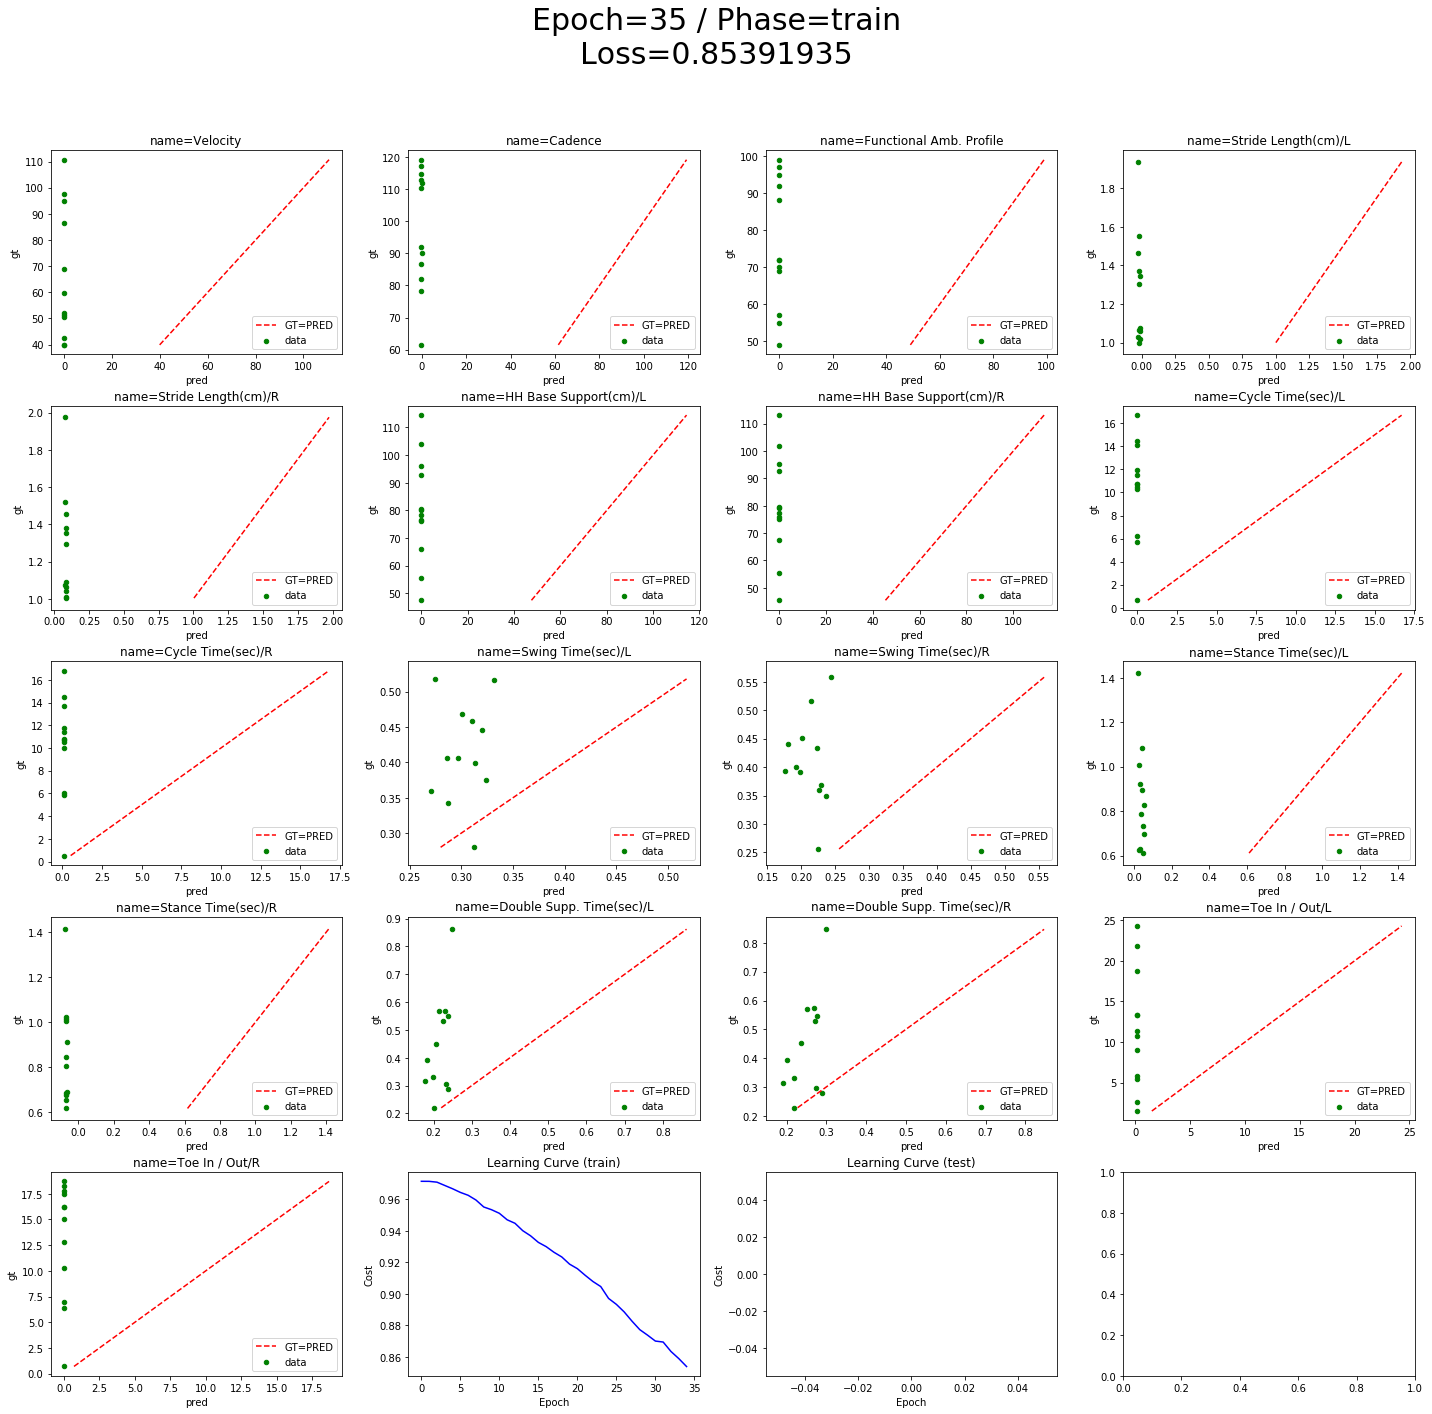

0.851908147031272


In [ ]:
# cost history saving..
history = {'train': [],
           'test': []}

import torch.optim as optim
from torch.optim import lr_scheduler

# Observe that all parameters are being optimized
# opt = optim.Adam(net.parameters(), lr=1e-3)
        
        
# opt = MultipleOptimizer(optim.SGD(net.module.shared_net.parameters(), lr=1e-2), 
#                         optim.SGD(net.module.reg_summary.parameters(), lr=1e-2),
#                         optim.SGD(net.module.reg_distance.parameters(), lr=1e-2),
#                         optim.SGD(net.module.reg_time.parameters(), lr=1e-2),
#                         optim.SGD(net.module.reg_angle.parameters(), lr=1e-2))


# optimizer = optim.RMSprop(net.parameters(), lr=1e-2)
opt = optim.SGD(net.parameters(), lr=0.001, momentum=0.9, nesterov=True)

info = collections.namedtuple("monitor_info",
                              "epoch phase res targets columns avg_loss history")

target_columns = list(chain(*dataset['train'].target_groups.values()))
end_epoch = 200

print("Start training loop...")

for epoch in range(1,end_epoch+1):        
    for phase in ['train']:
        try:
            
            if phase=='train':
                net.train()
            elif phase=='test':
                net.eval()
            
            list_res_and_targets = []

            running_loss = 0.0
            
            for idx, batch_item in enumerate(dataloader[phase]):
                _inputs, _targets = batch_item['inputs'].to(device),batch_item['targets'].to(device)
#                 { k: v.to(device) for k,v in batch_item['targets'].items() }
                opt.zero_grad()

                with torch.set_grad_enabled(phase=='train'):
                    # feed data to network
                    _res = net(_inputs)
                    
                    _loss = criterion(_res.double(), _targets.double())
                    
                    _res = _res.detach().cpu().numpy()
                    _targets = _targets.detach().cpu().numpy()
                    
#                     multi_loss = MultipleLossBP(*[ criterion(_res[k].double(),_targets[k].double()) for k in _targets.keys() ])
                    
#                     # average of multiple losses
#                     _loss = torch.mean(torch.tensor(multi_loss.losses))

#                     _res = np.hstack([ _res[k].detach().cpu().numpy() for k in _res.keys() ])
#                     _targets = np.hstack([ _targets[k].detach().cpu().numpy() for k in _targets.keys() ])
                    
                    print(_loss.item())
                    list_res_and_targets.append( (_res,_targets) )

                    if phase=='train':
                        _loss.backward()
                        opt.step()

                running_loss += _loss.item() * len(_inputs)
                
            avg_loss = running_loss / len(dataloader[phase].dataset)
            history[phase].append(avg_loss)
            
            res, targets = np.concatenate(list_res_and_targets,1)

            info_tuple = info(epoch, phase, res, targets, target_columns, avg_loss, history)

            monitor_lerning_process(info_tuple)
                
                
                
        except KeyboardInterrupt:
            break


plt.close()
print("Done!!")